# Titanic: Who will survive?
## Author Dustin Burnham
### Date Started: 9/29/2019

#### Outline:
1. Read in Data
2. Clean Data
3. EDA
4. Build and Test Logistic Regression Model
5. Build and Test Random Forrest Model
6. Build and Test XGBoosted Ensemble Model
7. Summary

The purpose of this project is to predict who survived the sinking of the Titanic based off of their personal information.  I will try using a logistic regression, random forrest, and XGBoosted ensemble models to classify into "1" survived, and "0" did not survive.  The data has already been split by the folks at Kaggle into training and testing data, however I will combine them for the purpose of EDA.

In [106]:
# Read in Libraries
from sklearn import svm, metrics
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

### Read in data

In [198]:
# Read in data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

### 2. Clean Data

In [207]:
train_data['Name'].head(15)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
Name: Name, dtype: object

In [212]:
split_1 = train_data['Name'].str.split(',', expand=True)
split_2 = split_1.loc[:,1].str.split(' ', expand=True)
train_data['last_name'] = split_1.loc[:,0]
train_data['title'] = split_2.loc[:,1]

In [213]:
split_1 = test_data['Name'].str.split(',', expand=True)
split_2 = split_1.loc[:,1].str.split(' ', expand=True)
test_data['last_name'] = split_1.loc[:,0]
test_data['title'] = split_2.loc[:,1]

In [214]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,last_name,title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Kelly,Mr.
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Wilkes,Mrs.
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Myles,Mr.
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Wirz,Mr.
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Hirvonen,Mrs.


In [215]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
last_name       object
title           object
dtype: object

In [216]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
last_name        0
title            0
dtype: int64

In [217]:
len(train_data)

891

In [218]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
last_name        0
title            0
dtype: int64

In [219]:
len(test_data)

418

#### Decision:
For creating a model, I will drop the "PassengerID", "Ticket", and "Cabin" columns.  Roughly 75% of the cabin values are NA, however we might be able to do some feature engineering to get the first letter of the Cabin.

In [220]:
train_data = train_data.drop(["PassengerId", "Cabin", "Ticket"], axis = 1)
test_data = test_data.drop(["PassengerId", "Cabin", "Ticket"], axis = 1)

#### Fix NAs in the age variable

In [221]:
med_male_age = np.nanmedian(train_data.loc[train_data["Sex"] == "male",'Age'])
mean_male_age = np.nanmean(train_data.loc[train_data["Sex"] == "male",'Age'])
med_female_age = np.nanmedian(train_data.loc[train_data["Sex"] == "female",'Age'])
mean_female_age = np.nanmean(train_data.loc[train_data["Sex"] == "female",'Age'])

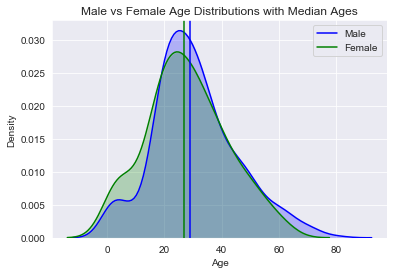

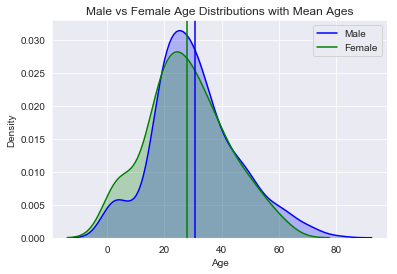

In [222]:
sns.set_style("darkgrid")
sns.kdeplot(train_data.loc[train_data["Sex"] == "male",'Age'].dropna(axis=0), shade = True, label ="Male", color = 'b')
sns.kdeplot(train_data.loc[train_data["Sex"] == "female",'Age'].dropna(axis=0), shade = True, label ="Female", color = 'g')
plt.axvline(med_male_age, 0,1, color = 'b', label = "Median Age Male")
plt.axvline(med_female_age, 0,1, color = 'g', label = "Median Age Female")
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Male vs Female Age Distributions with Median Ages")
plt.show()

sns.kdeplot(train_data.loc[train_data["Sex"] == "male",'Age'].dropna(axis=0), shade = True, label = "Male", color = 'b')
sns.kdeplot(train_data.loc[train_data["Sex"] == "female",'Age'].dropna(axis=0), shade = True, label = "Female", color = 'g')
plt.axvline(mean_male_age, 0,1, color = 'b', label = "Mean Age Male")
plt.axvline(mean_female_age, 0,1, color = 'g', label = "Mean Age Female")
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Male vs Female Age Distributions with Mean Ages")
plt.show()

In [223]:
print("Male Median Age: %3.2f" % med_male_age)
print("Male Mean Age: %3.2f" % mean_male_age)
print("Feale Median Age: %3.2f" % med_female_age)
print("Feale Mean Age: %3.2f" % mean_female_age)

Male Median Age: 29.00
Male Mean Age: 30.73
Feale Median Age: 27.00
Feale Mean Age: 27.92


#### Decision:
Because the distributions are right skewed, I will use the median instead of mean for each gender to replace NaN values.

In [224]:
train_data.loc[(train_data["Age"].isnull()) & (train_data['Sex'] == "female"),"Age"] = med_female_age
train_data.loc[(train_data["Age"].isnull()) & (train_data['Sex'] == "male"),"Age"] = med_male_age
test_data.loc[(test_data["Age"].isnull()) & (test_data['Sex'] == "female"),"Age"] = med_female_age
test_data.loc[(test_data["Age"].isnull()) & (test_data['Sex'] == "male"),"Age"] = med_male_age

Text(0.5, 1.0, 'Fare Distribution')

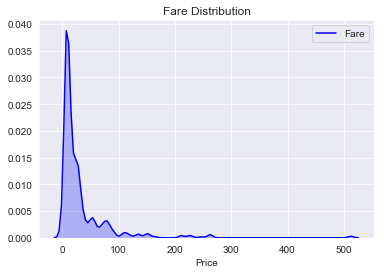

In [225]:
sns.kdeplot(train_data["Fare"], color = 'b', shade = True)
plt.xlabel("Price")
plt.title("Fare Distribution")

In [226]:
train_data.isna().sum()

Survived     0
Pclass       0
Name         0
Sex          0
Age          0
SibSp        0
Parch        0
Fare         0
Embarked     2
last_name    0
title        0
dtype: int64

In [227]:
test_data.isna().sum()

Pclass       0
Name         0
Sex          0
Age          0
SibSp        0
Parch        0
Fare         1
Embarked     0
last_name    0
title        0
dtype: int64

#### Decision:
Because the distribution is very right skewed and non-normal, I will just drop the one row with NaN fare.

In [228]:
print('Resampled dataset shape {}'.format(Counter(train_data["Embarked"])))

Resampled dataset shape Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})


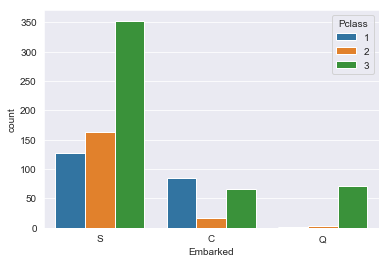

In [229]:
sns.countplot(x = "Embarked", hue = "Pclass", data=train_data)

In [230]:
s_emb = train_data.loc[train_data['Embarked'] == 'S',:]
c_emb = train_data.loc[train_data['Embarked'] == 'C',:]
q_emb = train_data.loc[train_data['Embarked'] == 'Q',:]

In [231]:
c_emb['Pclass'].mode()


0    1
dtype: int64

In [232]:
def plot_embarked(data, variable, metric):
    sns.set_style("darkgrid")
    sns.kdeplot(data.loc[data["Embarked"] == "S",variable].dropna(axis=0), shade = True, label ="Southampton", color = 'b')
    sns.kdeplot(data.loc[data["Embarked"] == "C",variable].dropna(axis=0), shade = True, label ="Cherbourg", color = 'g')
    sns.kdeplot(data.loc[data["Embarked"] == "Q",variable].dropna(axis=0), shade = True, label ="Queenstown", color = 'r')
    
    if metric == 'mean':
        s_met = np.nanmean(data.loc[data["Embarked"] == "S",variable])
        c_met = np.nanmean(data.loc[data["Embarked"] == "C",variable])
        q_met = np.nanmean(data.loc[data["Embarked"] == "Q",variable])
    elif metric == 'median':
        s_met = np.nanmedian(data.loc[data["Embarked"] == "S",variable])
        c_met = np.nanmedian(data.loc[data["Embarked"] == "C",variable])
        q_met = np.nanmedian(data.loc[data["Embarked"] == "Q",variable])
    else:
        raise ValueError()
    
    plt.axvline(s_met, 0,1, color = 'b', label = metric + variable + " Southampton")
    plt.axvline(c_met, 0,1, color = 'g', label = metric + variable + " Cherbourg")
    plt.axvline(q_met, 0,1, color = 'r', label = metric + variable + " Queenstown")
    plt.xlabel(variable)
    plt.ylabel("Density")
    plt.title("Embarked Distributions with " + metric + " " + variable)
    plt.show()

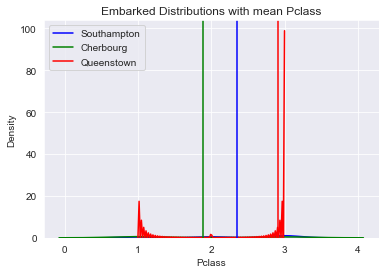

In [233]:
plot_embarked(train_data, 'Pclass', 'mean')

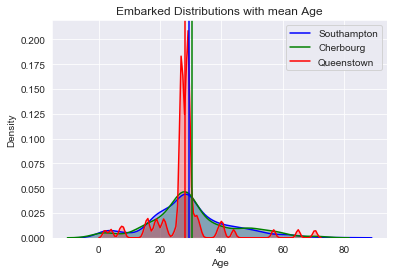

In [234]:
plot_embarked(train_data, 'Age', 'mean')

In [235]:
train_data.loc[(train_data["Embarked"].isnull()) & ((train_data["Pclass"] == 3) | (train_data["Pclass"] == 2)),"Embarked"] = 'S'
train_data.loc[(train_data["Embarked"].isnull()) & (train_data["Pclass"] == 1),"Embarked"] = 'C'

In [236]:
test_data.loc[(test_data["Embarked"].isnull()) & ((test_data["Pclass"] == 3) | (test_data["Pclass"] == 2)),"Embarked"] = 'S'
test_data.loc[(test_data["Embarked"].isnull()) & (test_data["Pclass"] == 1),"Embarked"] = 'C'

#### Decision:
Because the classification of where a person embarked from has an impact on whether a person survived or not, I will drop the two rows that have no embarked.

In [237]:
train_data = train_data.dropna(axis=0)
test_data = test_data.dropna(axis=0)

### Feature Engineering:
Now that data missingness has been addressed, now we turn to feature engineering.  Initial thoughts:
1. Family size by combining sibsp (sibling/spouse) and parch (parent/children) variables
2. Name Title
3. Cabin or not a Cabin (Maybe cabin class?)

In [238]:
cat_vars_train = list(train_data.dtypes.index[train_data.dtypes == 'object'])
cat_vars_test = list(test_data.dtypes.index[test_data.dtypes == 'object'])

In [239]:
# One hot encode variables
handle = "value" # error return_nan value indicator
onehoter =  ce.OneHotEncoder(return_df = True, 
                       cols = cat_vars_train, 
                       drop_invariant = False,
                       use_cat_names = True, 
                       handle_missing = handle, 
                       handle_unknown = handle)

onehoter.fit(train_data)
encoded_train = onehoter.transform(train_data)

handle = "value" # error return_nan value indicator
onehoter =  ce.OneHotEncoder(return_df = True, 
                       cols = cat_vars_test, 
                       drop_invariant = False,
                       use_cat_names = True, 
                       handle_missing = handle, 
                       handle_unknown = handle)
onehoter.fit(test_data)
encoded_test = onehoter.transform(test_data)

In [240]:
# Scale train and test data using min max scaling
names = encoded_train.columns
scaler = MinMaxScaler()
scaler.fit(encoded_train)
scaled_train = scaler.transform(encoded_train)
scaled_train = pd.DataFrame(scaled_train, columns=names)

names = encoded_test.columns
scaler = MinMaxScaler()
scaler.fit(encoded_test)
scaled_test = scaler.transform(encoded_test)
scaled_test = pd.DataFrame(scaled_test, columns=names)

## Summary:

### 3. EDA

In [ ]:
sns.pairplot(scaled_train, hue = "Survived")

### Split into features and target

In [26]:
X_train = scaled_train.drop(["Survived"], axis=1)
y_train = scaled_train["Survived"]

### 4. Logistic Regression

In [27]:
clf_lr = LogisticRegressionCV(cv=5, random_state=42)
clf_lr = clf_lr.fit(X_train, y_train)

In [28]:
clf_lr.score(X_train, y_train)

0.8008998875140607

### 5. Random Forrest

In [29]:
hypers_rf = {"n_estimators":[50, 75, 100, 125, 150], 
             "max_depth":[5, 10, 15, 20, 25, 30], 
             "min_samples_leaf":[3, 4, 5, 6, 7, 8]}

clf_rf = RandomForestClassifier()
clf_rf = GridSearchCV(clf_rf, hypers_rf, cv=5, iid = False, return_train_score=True)

In [30]:
# Train Decision Tree
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [31]:
# Get hyper parameters that maximize performance
scores = list(clf_rf.cv_results_['mean_test_score'])
max_index = scores.index(max(scores))
params = clf_rf.cv_results_['params'][max_index]

In [32]:
# Print best parameters
print(params)

{'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 125}


In [33]:
# Print score of that model
scores[max_index]

0.8346664127467784

In [34]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
clf_rf.score(X_train, y_train)

/Users/dusty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9640044994375703

### 6. Gradient Boosted Ensemble Model

In [70]:
# Gradient boost hyper parameters
hypers_gb = {"n_estimators":[11, 12, 13, 14, 15], 
             "learning_rate":[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2], 
             "max_depth":[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 
             "min_samples_leaf":[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
clf_gb = GradientBoostingClassifier()
clf_gb = GridSearchCV(clf_gb, hypers_gb, cv=5, iid = False, return_train_score=True)

In [71]:
clf_gb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  validation_fractio

In [72]:
# Get hyper parameters that maximize performance
scores = list(clf_gb.cv_results_['mean_test_score'])
max_index = scores.index(max(scores))
params = clf_gb.cv_results_['params'][max_index]

In [73]:
# Print best parameters
print(params)

{'learning_rate': 0.19, 'max_depth': 15, 'min_samples_leaf': 15, 'n_estimators': 13}


In [74]:
# Print score of that model
scores[max_index]

0.8481749508030216